### Nodes for README:
- Treatment of PAR_Y regions in short id
- fields in index, ensembl equivalence
- default paths if not provided
- default assembly (GRCh19 < Gencode 20, GRCh38 >= 20)

### TODO:
- Implement approximate search by name

In [1]:
import sys
import os
from os import path,listdir
import subprocess
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import re 
import gzip
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [111]:
##################################
### Plotting variables
##################################
legend_colors = {'latest':'#1a9850','mapped':'#fc8d59', 'deprecated':'#d73027'}
legend_elements = [Line2D([0], [0], marker='o', color='white', label=k,markerfacecolor=v, markersize=15) 
                   for k,v in legend_colors.items()]


##################################
### General methods
##################################

def Call(s):
    subprocess.call(s, shell=True, executable='/bin/bash')
    
    
def bed_sort(input_file):
    call = "sort -k1,1 -k2,2n -o '%s' '%s'"%(input_file,input_file)    
    Call(call)
    
    
def gtf_sort(input_file):
    call = "sort -k1,1 -k4,4n -o '%s' '%s'"%(input_file,input_file)    
    Call(call)
        
        
def microparser(line):
    if len(line.strip())==0:
        return None
    X = line.strip().split('\t')        
    r = {a.split(' ')[0]:a.split(' ')[1].replace('"','') for a in [x.strip() for x in X[8].split(';') if len(x.strip())>0]}
    r.update({'chr':X[0],'start':X[3],'end':X[4],'strand':X[6],'feature':X[2]})
    return r


def parse_meta(text):
    assembly = re.findall('human genome \((.*)\),',text)[0].strip()
    version = re.findall('version (.*) \(',text)[0].strip()
    ensembl = re.findall('Ensembl (.*)\)',text)[0].strip()
    _date = re.findall('date: (.*)',text)[0].strip()
    return {'gencode':version,'assembly':assembly,'ensembl':ensembl,'date':_date}


##################################
### Main class definition
##################################

class GHTracker:
    def __init__(self,download_path=None,index_path=None,LATEST_VERSION=37):
        self.download_path = download_path
        self.index_path = index_path
        self.LATEST_VERSION = LATEST_VERSION
    
    ##################################
    ### Class properties
    ##################################
    @property
    def download_path(self):        
        return self._download_path
    
    @download_path.setter
    def download_path(self,download_path):
        if download_path is None:
            d = path.abspath(os.getcwd())            
        else:
            d = path.abspath(download_path)
        self._download_path = d
        self.raw_path = path.join(self.download_path,'raw')
        self.gene_path = path.join(self.download_path,'gene')
        self.meta_path = path.join(self.download_path,'meta')
#         for folder in [self.download_path, self.raw_path, self.gene_path, self.meta_path]:
#             if not path.exists(folder):
#                 os.makedirs() 
        
    @property
    def index_path(self):        
        return self._index_path
    
    @index_path.setter
    def index_path(self,index_path):
        if index_path is None:
            d = path.abspath(os.getcwd())
        else:
            d = path.abspath(index_path)
        #Only reload data structures if new path is different
        if (hasattr(self, '_index_path')) and (self._index_path == d):
            return
        self._index_path = d        
        self.ensembl_eq = path.join(self.index_path,'ensembl_equivalence.csv')
        self.gene_index = path.join(self.index_path,'gene_index.csv.gz')
        self.gene_graph = path.join(self.index_path,'gene_network.gml')
        self.df_index = None
        self.df_index_last = None
        self.df_ensembl = None
        self.G = None
        self.GR = None
        
    def load_index(self,index_path=None):
        if index_path is not None:
            self.index_path = index_path
        #TODO: CHECK IF INDEX FILES EXIST
        # Load if is not loaded before or index_path changed
        if self.df_index is None:
            df = pd.read_csv(self.gene_index)
            df = df[['gene_shortid','gene_id','gene_name','hgnc_id','gene_type','coord','gencode']]
            df2 = pd.read_csv(self.ensembl_eq)
            df = pd.merge(df,df2,left_on='gencode',right_on='gencode')
            dfx = df.sort_values(by=['gene_shortid','gencode'],ascending=[True,False]).drop_duplicates(subset=['gene_shortid'],keep='first')
            self.df_index = df
            self.df_index_last = dfx
            self.df_ensembl = df2
        print('Entries:',len(self.df_index))
        
    def load_graph(self,index_path=None):
        if index_path is not None:
            self.index_path = index_path
        #TODO: CHECK IF INDEX FILES EXIST
        # Load if is not loaded before or index_path changed
        if self.G is None:
            G = nx.read_gml(self.gene_graph)
            GR = G.reverse()
            self.G = G
            self.GR = GR
        print('Nodes:',len(self.G.nodes()),'Edges:',len(self.G.edges()))
        
    ##################################
    ### Query methods
    ##################################
    def query_by_geneid_list(self,gene_list,output_tsv=None):
        DF = self.df_index_last
        LATEST_VERSION = self.LATEST_VERSION
        gene_set = set(gene_list)
        dfx = DF[(DF['gene_id'].isin(gene_set))|(DF['gene_shortid'].isin(gene_set))].copy()    
        dfx['deprecated'] = dfx['gencode'].apply(lambda x:int(x!=LATEST_VERSION))
        dfx = dfx.reset_index(drop=True)
        if output_tsv is not None:
            dfx.to_csv(output_tsv,sep='\t',index=None)
        return dfx

    def query_geneid_history(self,gene_id,output_tsv=None):
        DF = self.df_index
        dfx = DF[(DF['gene_id']==gene_id)|(DF['gene_shortid']==gene_id)].copy()    
        dfx = dfx.sort_values(by=['gene_shortid','gencode'],ascending=[True,False])    
        dfx = dfx.reset_index(drop=True)
        if output_tsv is not None:
            dfx.to_csv(output_tsv,sep='\t',index=None)
        return dfx

    def query_genename_history(self,gene_name,output_tsv=None):
        DF = self.df_index
        dfx = DF[(DF['gene_name']==gene_name)].copy()
        short_ids = set(dfx['gene_shortid'].unique())
        dfx = DF[DF['gene_shortid'].isin(short_ids)]
        dfx = dfx.sort_values(by=['gene_shortid','gencode'],ascending=[True,False])
        dfx = dfx.reset_index(drop=True)
        if output_tsv is not None:
            dfx.to_csv(output_tsv,sep='\t',index=None)
        return dfx

    def putative_mappings(self,gene_list):
        G = self.G
        rows = []
        for gene in gene_list:
            u,u_coord,u_version = gene,G.nodes()[gene]['coord'],G.nodes()[gene]['version']
            g1 = dfs_tree(G,gene)        
            v,v_coord = None,None
            for x in g1.nodes():                        
                if G.nodes()[x]['status']=='latest':
                    path_info = ';'.join([G.edges[e]['label'] for e in nx.path_graph(nx.shortest_path(G,gene,x)).edges()])                
                    v,v_coord,v_version = x,G.nodes()[x]['coord'],G.nodes()[x]['version']
                    rows.append((u,u_coord,u_version,v,v_coord,v_version,path_info))
            if v is None:
                rows.append((u,u_coord,u_version,np.nan,np.nan,-1,np.nan))
        R = pd.DataFrame(rows,columns=['query_id','query_coords','query_version','target_id','target_coords','target_version','path'])
        R = R[['query_id','target_id','query_coords','target_coords','query_version','target_version','path']]    
        return R
    
    def plot_gene_subtree(self,gene_shortid,full_tree=False,output_img=None,output_gml=None,figsize=(15,15)):
        G = self.G
        GR = self.GR
        node = gene_shortid
        g1 = dfs_tree(G,node)
        g2 = dfs_tree(GR,node)
        if not full_tree:
            gs = G.subgraph(set(g1.nodes())|set(g2.nodes()))
        else:
            _s = set()
            for n in g2.nodes():
                _s |= dfs_tree(G,n).nodes()
            gs = G.subgraph(_s)

        fig,ax = plt.subplots(figsize=figsize)
        ax.set_title(node+' ID history')
        args = '-Grankdir="LR"'
        #pos = graphviz_layout(gs, prog='dot',args=args)
        #pos = nx.spring_layout(gs)
        pos = graphviz_layout(gs, prog='neato')    
        pos_labels = {k: (v[0],v[1]*1.0) for k,v in pos.items()}
        nodelist = gs.nodes()
        edgelist = gs.edges()
        node_color = [G.nodes[x]['color'] for x in nodelist]
        node_labels = {x:'%s\nv%d'%(x,G.nodes[x]['version']) for x in nodelist}            
        edge_labels = {x:nx.get_edge_attributes(G,'label')[x].replace(')(',')\n(') for x in edgelist}

        nx.draw_networkx_nodes(gs, pos, nodelist=[node],node_color='darkgray',node_size = 500)
        nx.draw_networkx_nodes(gs, pos, nodelist=nodelist,node_color=node_color,node_size = 200)
        plotted_labels = nx.draw_networkx_labels(gs, pos_labels, labels=node_labels, verticalalignment='top',font_weight='bold')
        nx.draw_networkx_edges(gs, pos, edgelist=edgelist,edge_color='blue',arrows=True)    
        nx.draw_networkx_edge_labels(gs,pos,edge_labels=edge_labels,font_color='blue')

        x_values, y_values = zip(*pos.values())
        x_max = max(x_values)
        x_min = min(x_values)
        x_margin = (x_max - x_min) * 0.2
        plt.xlim(x_min - x_margin, x_max + x_margin)    
        ax.legend(handles=legend_elements, loc='best',fontsize=12)    
        if output_img is not None:
            _ = ax.axis('off')
            plt.savefig(output_img, bbox_inches='tight')
        if output_gml is not None:
            nx.write_gml(gs,output_gml)
        plt.show()    
    ##################################
    ### Download methods
    ##################################
    
    
    ##################################
    ### Building methods
    ##################################

In [112]:
GH = GHTracker(index_path='index')

In [113]:
GH.load_index()
GH.load_graph()

Entries: 1888250
Nodes: 74720 Edges: 3156


---

In [92]:
gene_list = [
    'ENSG00000230544',
    'ENSG00000240453',
    'ENSG00000254100',
    'ENSG00000259484',
    'ENSG00000259758',
    'ENSG00000260940',
    'ENSG00000261496',
    'ENSG00000261685',
    'ENSG00000266584',
    'ENSG00000122952',
    'ENSG00000253827'
]

---
---

In [108]:
def query_by_geneid_list(DF,LATEST_VERSION,gene_list,output_tsv=None):
    gene_set = set(gene_list)
    dfx = DF[(DF['gene_id'].isin(gene_set))|(DF['gene_shortid'].isin(gene_set))].copy()    
    dfx['deprecated'] = dfx['gencode'].apply(lambda x:int(x!=LATEST_VERSION))
    dfx = dfx.reset_index(drop=True)
    if output_tsv is not None:
        dfx.to_csv(output_tsv,sep='\t',index=None)
    return dfx

def query_geneid_history(DF,gene_id,output_tsv=None):
    dfx = DF[(DF['gene_id']==gene_id)|(DF['gene_shortid']==gene_id)].copy()    
    dfx = dfx.sort_values(by=['gene_shortid','gencode'],ascending=[True,False])    
    dfx = dfx.reset_index(drop=True)
    if output_tsv is not None:
        dfx.to_csv(output_tsv,sep='\t',index=None)
    return dfx

def query_genename_history(DF,gene_name,output_tsv=None):
    dfx = DF[(DF['gene_name']==gene_name)].copy()
    short_ids = set(dfx['gene_shortid'].unique())
    dfx = DF[DF['gene_shortid'].isin(short_ids)]
    dfx = dfx.sort_values(by=['gene_shortid','gencode'],ascending=[True,False])
    dfx = dfx.reset_index(drop=True)
    if output_tsv is not None:
        dfx.to_csv(output_tsv,sep='\t',index=None)
    return dfx

def putative_mappings(G,gene_list):
    rows = []
    for gene in gene_list:
        u,u_coord,u_version = gene,G.nodes()[gene]['coord'],G.nodes()[gene]['version']
        g1 = dfs_tree(G,gene)        
        v,v_coord = None,None
        for x in g1.nodes():                        
            if G.nodes()[x]['status']=='latest':
                path_info = ';'.join([G.edges[e]['label'] for e in nx.path_graph(nx.shortest_path(G,gene,x)).edges()])                
                v,v_coord,v_version = x,G.nodes()[x]['coord'],G.nodes()[x]['version']
                rows.append((u,u_coord,u_version,v,v_coord,v_version,path_info))
        if v is None:
            rows.append((u,u_coord,u_version,np.nan,np.nan,-1,np.nan))
    R = pd.DataFrame(rows,columns=['query_id','query_coords','query_version','target_id','target_coords','target_version','path'])
    R = R[['query_id','target_id','query_coords','target_coords','query_version','target_version','path']]    
    return R

def plot_gene_subtree(G,GR,node,full_tree=False,output_img=None,output_gml=None,figsize=(15,15)):
    g1 = dfs_tree(G,node)
    g2 = dfs_tree(GR,node)
    if not full_tree:
        gs = G.subgraph(set(g1.nodes())|set(g2.nodes()))
    else:
        _s = set()
        for n in g2.nodes():
            _s |= dfs_tree(G,n).nodes()
        gs = G.subgraph(_s)
    
    fig,ax = plt.subplots(figsize=figsize)
    ax.set_title(node+' ID history')
    args = '-Grankdir="LR"'
    #pos = graphviz_layout(gs, prog='dot',args=args)
    #pos = nx.spring_layout(gs)
    pos = graphviz_layout(gs, prog='neato')    
    pos_labels = {k: (v[0],v[1]*1.0) for k,v in pos.items()}
    nodelist = gs.nodes()
    edgelist = gs.edges()
    node_color = [G.nodes[x]['color'] for x in nodelist]
    node_labels = {x:'%s\nv%d'%(x,G.nodes[x]['version']) for x in nodelist}            
    edge_labels = {x:nx.get_edge_attributes(G,'label')[x].replace(')(',')\n(') for x in edgelist}
    
    nx.draw_networkx_nodes(gs, pos, nodelist=[node],node_color='darkgray',node_size = 500)
    nx.draw_networkx_nodes(gs, pos, nodelist=nodelist,node_color=node_color,node_size = 200)
    plotted_labels = nx.draw_networkx_labels(gs, pos_labels, labels=node_labels, verticalalignment='top',font_weight='bold')
    nx.draw_networkx_edges(gs, pos, edgelist=edgelist,edge_color='blue',arrows=True)    
    nx.draw_networkx_edge_labels(gs,pos,edge_labels=edge_labels,font_color='blue')
    
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.2
    plt.xlim(x_min - x_margin, x_max + x_margin)    
    ax.legend(handles=legend_elements, loc='best',fontsize=12)    
    if output_img is not None:
        _ = ax.axis('off')
        plt.savefig(output_img, bbox_inches='tight')
    if output_gml is not None:
        nx.write_gml(gs,output_gml)
    plt.show()    

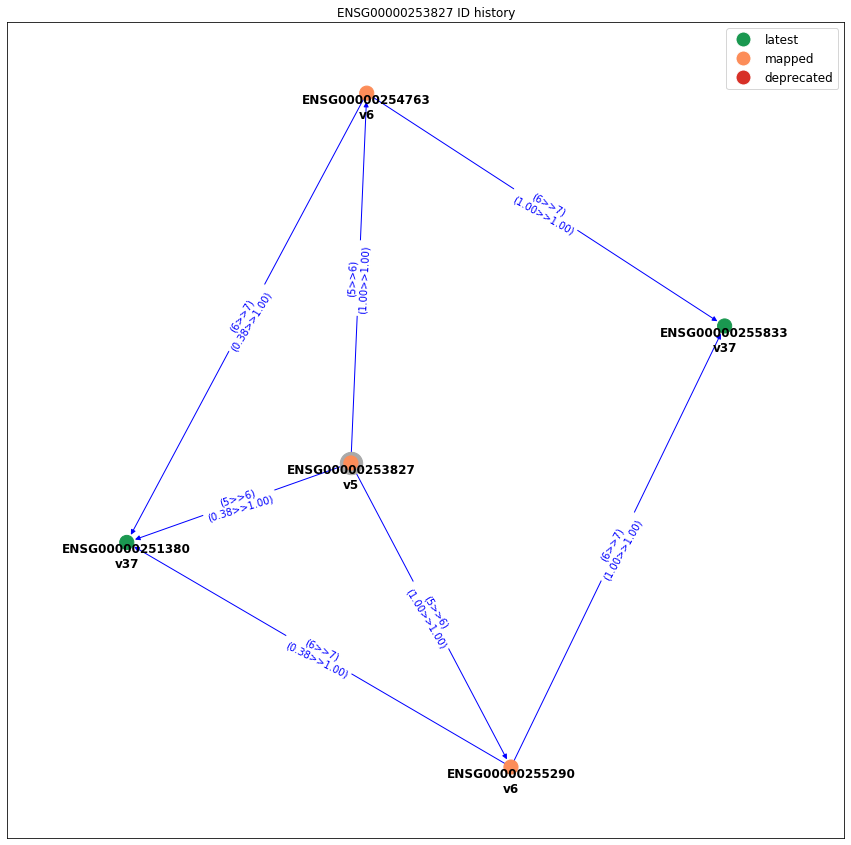

In [115]:
#query_by_geneid_list(GH.df_index_last,GH.LATEST_VERSION,gene_list)
#query_geneid_history(GH.df_index,'ENSG00000251562')
#query_genename_history(GH.df_index,'MALAT1')
#putative_mappings(GH.G,gene_list)
plot_gene_subtree(GH.G,GH.GR,'ENSG00000253827',full_tree=True)

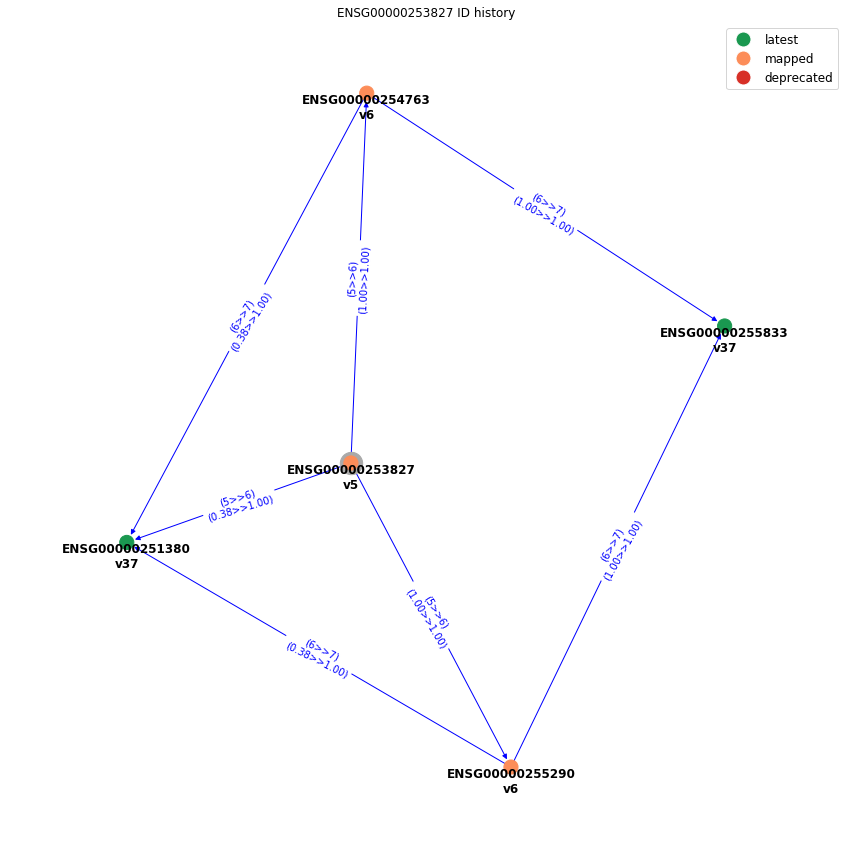

In [114]:
#GH.query_by_geneid_list(gene_list)
#GH.putative_mappings(gene_list)
GH.plot_gene_subtree('ENSG00000253827',output_img='img/map_example.png',output_gml='img/map_example.gml')